<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/test(mobilenet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
ROOT_DIR = '/content/drive/MyDrive/PCOS'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
   print("",dir,"" ,number_of_images[dir])

 infected  5000
 noninfected  5000


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = []
for category in ['infected', 'noninfected']:
    folder_path = os.path.join(ROOT_DIR, category)
    for img in os.listdir(folder_path):
        data.append({'filepath': os.path.join(folder_path, img), 'label': category})

df = pd.DataFrame(data)

# Splitting 70/15/15
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

# Augmentation for Training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only Preprocessing for Val/Test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)

Found 7000 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load MobileNet without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing the base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x) # More efficient than Flatten for MobileNet
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('pcos_mobilenet.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25, # Adjusted based on typical PCOS convergence
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7951 - loss: 0.4265

219/219 ━━━━━━━━━━━━━━━━━━━━ 1095s 5s/step - accuracy: 0.7954 - loss: 0.4259 - val_accuracy: 0.9633 - val_loss: 0.1122
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.9221 - loss: 0.1836 - val_accuracy: 0.9213 - val_loss: 0.1431
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9419 - loss: 0.1489

219/219 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.9419 - loss: 0.1489 - val_accuracy: 0.9500 - val_loss: 0.1016
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9521 - loss: 0.1243 - val_accuracy: 0.9187 - val_loss: 0.1484
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.9541 - loss: 0.1235 - val_accuracy: 0.9493 - val_loss: 0.1078
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.9608 - loss: 0.1043 - val_accuracy: 0.9240 - val_loss: 0.1519
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - loss: 0.0889

219/219 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.9682 - loss: 0.0889 - val_accuracy: 0.9540 - val_loss: 0.0988
Epoch 8/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9689 - loss: 0.0845 - val_accuracy: 0.9460 - val_loss: 0.1132
Epoch 9/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.9739 - loss: 0.0813 - val_accuracy: 0.9407 - val_loss: 0.1270
Epoch 10/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9745 - loss: 0.0751

219/219 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.9745 - loss: 0.0751 - val_accuracy: 0.9600 - val_loss: 0.0879
Epoch 11/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9723 - loss: 0.0732 - val_accuracy: 0.9540 - val_loss: 0.0976
Epoch 12/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9788 - loss: 0.0694 - val_accuracy: 0.9620 - val_loss: 0.0884
Epoch 13/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9685 - loss: 0.0764 - val_accuracy: 0.9387 - val_loss: 0.1376
Epoch 14/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.9742 - loss: 0.0710 - val_accuracy: 0.9207 - val_loss: 0.1686
Epoch 15/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.9733 - loss: 0.0677 - val_accuracy: 0.9320 - val_loss: 0.1583


In [13]:
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

loss, accuracy = model.evaluate(test_gen)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

Found 1500 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9395 - loss: 0.1339
Final Test Accuracy: 94.93%


47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step


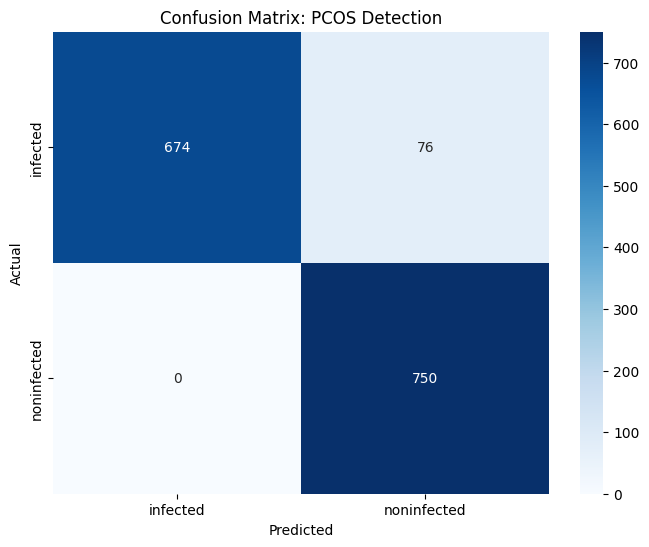


Classification Report:
              precision    recall  f1-score   support

    infected       1.00      0.90      0.95       750
 noninfected       0.91      1.00      0.95       750

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get predictions from the test set
# Important: shuffle=False in test_gen ensures labels match predictions
test_gen.reset()
predictions = model.predict(test_gen)
pred_labels = (predictions > 0.5).astype(int) # Convert probabilities to 0 or 1

# 2. Get true labels
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# 3. Create Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: PCOS Detection')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Detailed Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

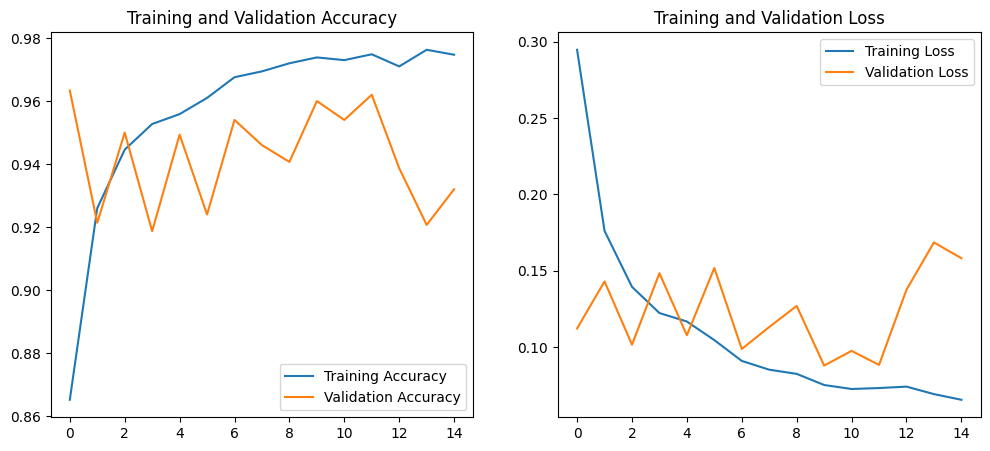

In [15]:
# Plotting Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [17]:
# Step 1: Upload image from your laptop
from google.colab import files
uploaded = files.upload()

# Step 2: Get the uploaded file name
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Define the prediction function
def predictimage(image_path):
    # Load the image and resize to target size
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)       # Preprocess for MobileNet

    # Make prediction
    prediction = model.predict(img_array)
    predicted_probability = prediction[0][0]

    # Interpret prediction (assuming binary classification: 0 for infected, 1 for noninfected based on train_gen.class_indices)
    # It's safer to get class names from the generator directly if available
    # We are using 'binary' class_mode, so 0 is the first class and 1 is the second.
    # Check train_gen.class_indices to confirm mapping.
    class_labels = list(train_gen.class_indices.keys())
    predicted_class_index = (predicted_probability > 0.5).astype(int)
    predicted_label = class_labels[predicted_class_index]

    print(f"Prediction for {os.path.basename(image_path)}:")
    print(f"  Probability: {predicted_probability:.4f}")
    print(f"  Predicted Class: {predicted_label}")

for fn in uploaded.keys():
    file_path = os.path.join("/content", fn)
    print("Uploaded file path:", file_path)

    # Step 3: Run prediction on the uploaded image
    predictimage(file_path)


Saving img_0_74.jpg to img_0_74 (1).jpg
Uploaded file path: /content/img_0_74 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
Prediction for img_0_74 (1).jpg:
  Probability: 0.0001
  Predicted Class: infected


In [18]:
# Step 1: Upload image from your laptop
from google.colab import files
uploaded = files.upload()

# Step 2: Get the uploaded file name
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Define the prediction function
def predictimage(image_path):
    # Load the image and resize to target size
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)       # Preprocess for MobileNet

    # Make prediction
    prediction = model.predict(img_array)
    predicted_probability = prediction[0][0]

    # Interpret prediction (assuming binary classification: 0 for infected, 1 for noninfected based on train_gen.class_indices)
    # It's safer to get class names from the generator directly if available
    # We are using 'binary' class_mode, so 0 is the first class and 1 is the second.
    # Check train_gen.class_indices to confirm mapping.
    class_labels = list(train_gen.class_indices.keys())
    predicted_class_index = (predicted_probability > 0.5).astype(int)
    predicted_label = class_labels[predicted_class_index]

    print(f"Prediction for {os.path.basename(image_path)}:")
    print(f"  Probability: {predicted_probability:.4f}")
    print(f"  Predicted Class: {predicted_label}")

for fn in uploaded.keys():
    file_path = os.path.join("/content", fn)
    print("Uploaded file path:", file_path)

    # Step 3: Run prediction on the uploaded image
    predictimage(file_path)

Saving img_0_28.jpg to img_0_28.jpg
Uploaded file path: /content/img_0_28.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction for img_0_28.jpg:
  Probability: 0.9967
  Predicted Class: noninfected
